# Investigating the Network

## Intro / Goal

## Setup

## Device Mapping

| IP                                    | Sven's Device | Maxi's Device | Fabi's Devices                         |
| ------------------------------------- | ------------- | ------------- | -------------------------------------- |
| 192.168.178.1                         | Router        |               |                                        |
| 192.168.178.21                        |               | Android Phone |                                        |
| 192.168.178.24                        | Google Home   |               |                                        |
| 192.168.178.26                        | Chromecast    |               |                                        |
| 192.168.178.27                        | Google Home   |               |                                        |
| 192.168.178.29                        | Google Home   |               |                                        |
| 192.168.178.42                        | Google Home   |               |                                        |
| 192.168.178.43                        | SmartTV       |               |                                        |
| 192.168.178.44                        | Android Phone |               |                                        |
| 192.168.178.50                        | iPad          |               |                                        |
| 192.168.178.51                        | MacBook       |               |                                        |
| 192.168.178.58                        | Vacuum Robot  |               |                                        |
| 192.168.178.59                        |               | Notebook      |                                        |
| 192.168.178.60                        | MacBook       |               |                                        |
| 192.168.178.62                        | iPhone        |               |                                        |
| 192.168.178.64                        | SmartTV       |               |                                        |
| 2003:c1:3720:f300:e96b:cc0b:be8f:e1e3 | GoogleHome    |               |                                        |
| fe80::d6f5:47ff:fe38:193b             | GoogleHome    |               |                                        |
| 2003:c1:3720:f300:99b8:9c2:5bc1:84be  | GoogleHome    |               |                                        |
| 2003:c1:3712:ac00:e9ad:724d:142a:c5c9 |               | Smartphone    |                                        |
| 2003:c1:3712:ac00:38ee:9c51:e7ee:fe52 |               | Notebook      |                                        |
| 192.168.0.1                           |               |               | Router                                 |
| 192.168.0.2                           |               |               | Wifi Smart Plug                        |
| 192.168.0.8                           |               |               | Amazon Fire TV                         |
| 192.168.0.9                           |               |               | Sonos Wifi Loudspeaker                 |
| 192.168.0.14                          |               |               | iPad                                   |
| 192.168.0.22                          |               |               | ESP32 Microcontroller                  |
| 192.168.0.88                          |               |               | Raspberry Pi used for network sniffing |
| 192.168.0.121                         |               |               | ESP32 with Feinstaubsensor firmware    |


In [1]:
# mapping for later sections
#devices_labels = ['Router (Sven)', 'Google Home (Sven)', 'Chromecast (Sven)', 'Smart TV (Sven)', 'Android Phone (Sven)', 'iPad (Sven)', 'MacBook (Sven)', 'Vacuum Robot (Sven)', 'iPhone (Sven)',
#                  'Android Phone (Maxi)', 'Notebook (Maxi)',]
# no router traffic is analyzed due to potential issues caused by device <--> router communication
# '192.168.178.1': 'Router (Sven)',
devices_mapping = {
                    '192.168.178.21': 'Android Phone (Maxi)',
                    '192.168.178.24': 'Google Home (Sven)',
                    '192.168.178.26': 'Chromecast (Sven)',
                    '192.168.178.27': 'Google Home (Sven)',
                    '192.168.178.29': 'Google Home (Sven)',
                    '192.168.178.42': 'Google Home (Sven)',
                    '192.168.178.43': 'Smart TV (Sven)',
                    '192.168.178.44': 'Android Phone (Sven)',
                    '192.168.178.50': 'iPad (Sven)',
                    '192.168.178.51': 'MacBook (Sven)',
                    '192.168.178.58': 'Vacuum Robot (Sven)',
                    '192.168.178.59': 'Notebook (Maxi)',
                    '192.168.178.60': 'MacBook (Sven)',
                    '192.168.178.62': 'iPhone (Sven)',
                    '192.168.178.64': 'Smart TV (Sven)',
                    '2003:c1:3720:f300:e96b:cc0b:be8f:e1e3': 'Google Home (Sven)',
                    'fe80::d6f5:47ff:fe38:193b': 'Google Home (Sven)',
                    '2003:c1:3720:f300:99b8:9c2:5bc1:84be': 'Google Home (Sven)',
                    '2003:c1:3712:ac00:e9ad:724d:142a:c5c9': 'Android Phone (Maxi)',
                    '2003:c1:3712:ac00:38ee:9c51:e7ee:fe52': 'Notebook (Maxi)',
                    '192.168.0.2':    "Wifi Smart Plug (Fabi)",
                    '192.168.0.8':    "Amazon Fire TV (Fabi)",
                    '192.168.0.9':    "Sonos Wifi Loudspeaker (Fabi)",
                    '192.168.0.14':   "iPad (Fabi)",
                    '192.168.0.22':   "ESP32 Microcontroller (Fabi)",
                    '192.168.0.88':   "Raspberry Pi used for network sniffing (Fabi)",
                    '192.168.0.121':  "ESP32 with Feinstaubsensor firmware (Fabi)",
}

devices_labels = list(set(devices_mapping.values()))

Start of the program

In [2]:
# Program, run imports
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import time
import seaborn as sns
import requests
sns.set(style="darkgrid")

# used to skip merging and filtering
new_read = False

Create Pandas Dataframe

In [3]:
if new_read:
    print('Concatenate csv files...')
    df_fabi = pd.read_csv("dumps/allPorts_fabian.csv", encoding = "latin")
    df_maxi = pd.read_csv("dumps/allPorts_maxi_v2.csv", encoding = "latin")
    df_sven = pd.read_csv("dumps/advanced-dumps-sven.csv", encoding = "latin")
    df = pd.concat([df_fabi, df_maxi, df_sven])
    print('Concatenate operation completed')
    print(len(df))

Filter Local Traffic

Print total number of captured packages

In [4]:
if new_read:
    time_filter_start = time.time()
    print('Compute intensive task filter started...')
    # source and destination should not start with 192.168 to filter local network. DNS should not be filtered.
    filtered = df.loc[~df['Source'].str.startswith("192.168", na=False) & df['Destination'].str.startswith("192.168", na=False) |
                    df['Source'].str.startswith("192.168", na=False) & ~df['Destination'].str.startswith("192.168", na=False) |
                    df['Protocol'].isin(['DNS'])]

    filtered = filtered.loc[~filtered['Protocol'].isin(['DHCP', 'ARP', 'MDNS', 'LLDP', 'SSDP', 'IGMP', 'IGMPv2', 'IGMPv3', 'ICMP', 'ICMPv4', 'ICMPv6', 'ieee1905', 'LLMNR'])]
    filtered = filtered.loc[~filtered['Destination'].isin(['255.255.255.255'])]


    df = filtered 

    # sort array by timestamp

    df = df.sort_values(by=['Time'])
    # save to csv
    # df.to_csv('df.csv')
    # print (df.loc[df['Destination'].str.contains("255.255.255.255")])
    time_filter_duration = time.time() - time_filter_start
    print('Task filter completed in ', time_filter_duration, ' seconds')
else:
    df = pd.read_csv('df.csv')


add a new device coulmn 'Device Name' for better readability

In [5]:
if not 'Device Name' in df.columns:
    new_read = True # save df later
    time_device_name_calc_start = time.time()
    print('Compute Device Name column...')
    #df_devices = pd.DataFrame({'Source': devices_mapping.keys(), 'Device Name': devices_mapping.values()})
    # df = df.merge(df_devices, on='Source', how='left')
    # Apply Device Name to incoming and outgoing packets
    df.loc[df['Source'].isin(devices_mapping.keys()), 'Device Name'] = df.loc[df['Source'].isin(devices_mapping.keys())].Source.apply(lambda x : devices_mapping[x])
    df.loc[df['Destination'].isin(devices_mapping.keys()), 'Device Name'] = df.loc[df['Destination'].isin(devices_mapping.keys())].Destination.apply(lambda x : devices_mapping[x])
    time_device_name_calc_duration = time.time() - time_device_name_calc_start
    print('Compute Device Name column completed in ', time_device_name_calc_duration, ' in seconds')
    print(df.head(10))

In [6]:
# helper functions
def utcEntryToTimestamp(entry):
    #if '.' in entry:
    row_entry = entry.split(".")[0]
    #else:
    #    row_entry = entry.split(",")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

def utcRowToTimestamp(row):
    return utcEntryToTimestamp(row.at['Time'])
utcRowToTimestamp(df.iloc[0])
# print(df.loc[0].at['Time'])


1642338171

In [7]:
min_15_duration = 60 * 15
# add index time column, if it doesn't exist yet
if not 'index-time' in df.columns:
    time_utc_calc_start = time.time()
    print('Compute index-time column (approx. 5min)...')
    df['index-time'] = df['Time'].apply(lambda x: utcEntryToTimestamp(x)) # .apply(lambda x: x)) # map to 15 min window
    first_entry_offset = df.iloc[0].at['index-time'] // min_15_duration
    df['index-time'] = (df['index-time'] // min_15_duration) - first_entry_offset
    new_read = True
    time_utc_calc_duration = time.time() - time_utc_calc_start
    print('index-time column task completed in ', time_utc_calc_duration, ' seconds')

Save df to csv / load df from csv

In [8]:
if new_read:
    df.to_csv('df.csv')

print(df)
print(len(df))

          Unnamed: 0      No.                        Time          Source  \
0                784      785  2022-01-16 14:02:51.208659  192.168.178.26   
1                785      786  2022-01-16 14:02:51.208898  192.168.178.26   
2                786      787  2022-01-16 14:02:51.226374         8.8.8.8   
3                787      788  2022-01-16 14:02:51.226379         8.8.8.8   
4               1241     1242  2022-01-16 14:02:52.665188  192.168.178.58   
...              ...      ...                         ...             ...   
29075213    47385143  4331530  2022-01-22 20:48:47.822966  192.168.178.59   
29075214    47385144  4331531  2022-01-22 20:48:47.824786  192.168.178.59   
29075215    47385145  4331532  2022-01-22 20:48:47.825238  192.168.178.59   
29075216    47385146  4331533  2022-01-22 20:48:47.826047  52.223.201.182   
29075217    47385147  4331534  2022-01-22 20:48:47.826252  52.223.201.182   

             Destination Protocol  Length  \
0                8.8.8.8      

## Protocols
We would like to start our investigations by getting a better insight about the Packet Types were are sending to the web.
Several protocols exist for sending data trough the web nowadays. Based on their purpose, these cane be assigned to Application, Transport and Internet layer.
- Application layer
  - DNS
  - SSH
  - HTTP
  - HTTPS
  - ...
- Transport Layer
  - TCP
  - UDP
  - QUICK
- Internet Layer
  - IP (IPv4, IPv6)
  - ICMP
  - ...   

Some of these protocols, such as HTTP, UDP and TCP are quite old. Others, such as the QUICK protocol, were only introduced in the recent years. 



### Protocol Distribution among Frames

To get a better overview about all the traffic our devices use the sent and receive data from the Internet, we print out a ranking and plot the data. \
We see that the mayority of our captured frames use **TCP*** as underlying protocol. This is not surprising, since TCP is the most used transport protocol and is almost used for every traffic on the web. \
Surprisingly, we also see **QUICK** in our top 5. QUICK, which was recently standardized in May 2021, seems to be heavily pushed by its creator Google. As you can see from our device list, Google devices claim a large share out of all devices. This might be the reason for its popularity among our captured frames.

Protocol
TCP          17435122
UDP           4461027
TLSv1.3       2956252
QUIC          1723579
TLSv1.2       1624978
STUN           392817
DNS            313507
HTTP            55261
TLSv1           43277
SSLv2           17215
RTCP            14732
NTP              6561
WireGuard        6550
UDPENCAP         6264
HTTP/JSON        4460
dtype: int64


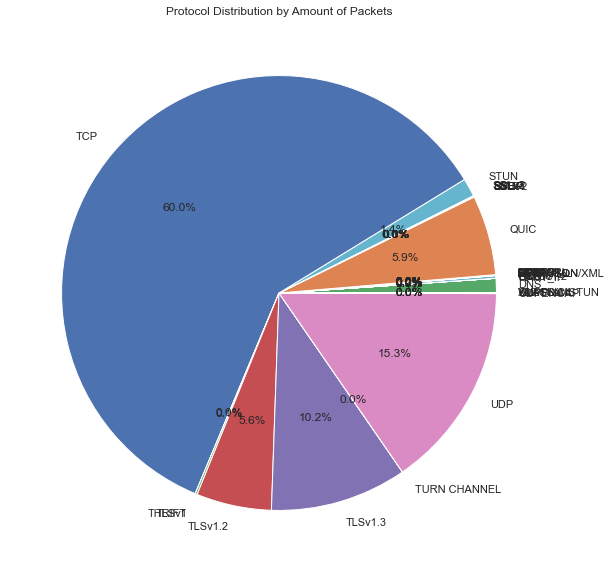

In [9]:
# rank by most used protocols
df_ranked_protocols = df.groupby('Protocol').size()
print(df_ranked_protocols.nlargest(15))

# plot pie diagram
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Protocol Distribution by Amount of Packets')
ax.pie(df_ranked_protocols, labels=df_ranked_protocols.keys(), autopct='%1.1f%%')
fig.show()

### Amount of Data Traffic per Protocol
We also had a look in the amount of data traffic that is sent by each protocol. It seemes that this heavily correlates with the protocol distribution among our captured frames. 

Protocol
TCP          15156860775
TLSv1.3       3447083021
UDP           2257930782
TLSv1.2       1150436991
QUIC           740530259
STUN           161666044
DNS             38356738
SSLv2           27975240
TLSv1           27480160
HTTP            26034150
RTCP             3545736
HTTP/JSON        2366719
WireGuard         806057
OCSP              727550
NTP               590490
Name: Length, dtype: int64


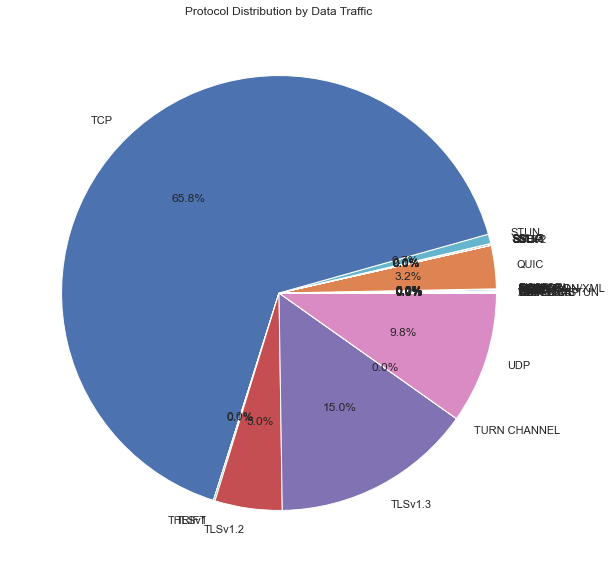

In [10]:
df_data_per_protocol = df.groupby('Protocol')['Length'].sum()
print(df_data_per_protocol.nlargest(15))

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Protocol Distribution by Data Traffic')
ax.pie(df_data_per_protocol, labels=df_data_per_protocol.keys(), autopct='%1.1f%%',)
fig.show()

### Average Data length per Protocol Type
In order to investigate which kind if protocol holds the most data, we compute the mean of each frame per protocol.
It seems that especially SSL and SSH have the greatest amount of data per frame. \
Surprisingly, we also some various industrial protocols, such as H1, PKIX-CRL and HART_IP in this ranking. These protocols are especially designed for sending large data packets. We are not very sure what programs on Maxi's laptop and phone are responsible for this and will investigate this further in a later section of this write-up.

Protocol
SSLv2       1625.050247
SSHv2       1369.213930
H1          1301.857143
TLSv1.3     1166.031523
PKIX-CRL     985.500000
HART_IP      906.666667
HTTP/XML     871.598131
TCP          869.329207
SSH          866.000000
THRIFT       845.000000
GQUIC        779.498113
TLSv1.2      707.970810
MP4          683.542056
OCSP         664.429224
TLSv1        634.983016
Name: Length, dtype: float64


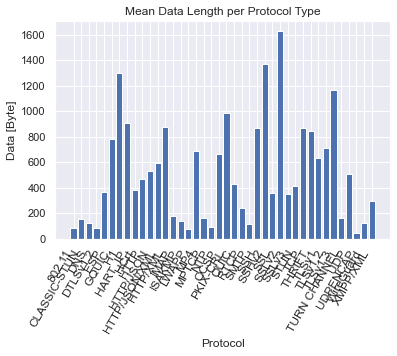

In [11]:
df_mean_protocol_packet_length = df.groupby('Protocol')['Length'].mean()
print(df_mean_protocol_packet_length.nlargest(15))
#print (df.loc[df['Protocol'].str.contains("HART_IP")])

# plot
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=12)
plt.xlabel('Protocol')
plt.ylabel('Data [Byte]')
plt.title('Mean Data Length per Protocol Type')
ax.bar(df_mean_protocol_packet_length.keys(), df_mean_protocol_packet_length, align='center',)
plt.xticks(rotation=60, ha="right")
fig.show()

## Source addresses

In [12]:
df_ranked_sources = df.groupby('Source').size()
print(df_ranked_sources.nlargest(25))

Source
192.168.178.59     5390544
52.223.201.182     2176128
52.223.201.100     1690406
52.113.63.202      1391369
178.79.232.14      1147835
192.168.0.22       1057390
188.164.238.26     1031790
134.224.101.38      803103
199.232.189.140     676313
85.114.135.172      638649
52.115.132.197      619752
192.168.178.21      601703
138.246.224.36      566972
192.168.178.44      513646
192.168.178.60      480876
199.232.138.248     479584
193.122.34.58       456708
185.42.205.193      445393
130.61.166.170      442012
190.115.31.242      356783
192.168.178.26      324134
52.223.201.183      262504
192.168.0.9         251129
134.224.83.155      250635
192.168.178.62      222697
dtype: int64


Local devices with most traffic sent

In [13]:
print(df.loc[df['Source'].str.startswith("192.168") & df['Source'].isin(devices_mapping.keys())].groupby(['Source', 'Device Name']).size())

Source          Device Name                                  
192.168.0.121   ESP32 with Feinstaubsensor firmware (Fabi)        132317
192.168.0.14    iPad (Fabi)                                         4559
192.168.0.2     Wifi Smart Plug (Fabi)                               286
192.168.0.22    ESP32 Microcontroller (Fabi)                     1057390
192.168.0.8     Amazon Fire TV (Fabi)                             131057
192.168.0.88    Raspberry Pi used for network sniffing (Fabi)       1569
192.168.0.9     Sonos Wifi Loudspeaker (Fabi)                     251129
192.168.178.21  Android Phone (Maxi)                              601703
192.168.178.24  Google Home (Sven)                                     1
192.168.178.26  Chromecast (Sven)                                 324134
192.168.178.27  Google Home (Sven)                                  1029
192.168.178.29  Google Home (Sven)                                 13757
192.168.178.42  Google Home (Sven)                            

## Destination Adresses

In [14]:
df_ranked_destinations = df.groupby('Destination').size()
print(df_ranked_destinations.nlargest(25))

Destination
192.168.178.59     13490022
192.168.178.60      1449268
188.164.238.26      1057066
192.168.0.22        1032089
192.168.178.21       941721
192.168.178.44       886675
52.223.201.182       792443
192.168.178.26       674651
52.223.201.100       641974
192.168.0.9          504343
199.232.189.140      393793
192.168.178.62       391508
130.61.166.170       311446
178.79.232.14        292140
193.122.47.231       273879
134.224.101.38       248261
199.232.138.248      211853
52.113.63.202        192247
138.246.224.36       186772
192.168.0.8          179189
134.224.83.155       175186
134.224.84.18        158159
85.114.135.172       157979
185.42.205.193       157829
52.115.132.197       134845
dtype: int64


In [15]:
# write ip address destinations to file
unique_dests = df['Destination'].unique()
file1 = open("destinations.txt","w")
for row in unique_dests:
    file1.write(row + "\n")
file1.close()

### IP Locations World Wide Sources (Incoming Traffic) ###

                 ip country      lng      lat                          isp
0    52.223.201.182      US -97.8220  37.7510                       TWITCH
1    52.223.201.100      US -97.8220  37.7510                       TWITCH
2     52.113.63.202      IE  -6.2591  53.3382  MICROSOFT-CORP-MSN-AS-BLOCK
3     178.79.232.14      US -97.8220  37.7510                         LLNW
4    188.164.238.26      DE  11.5658  48.1336            SWM Services GmbH
5    134.224.101.38      US -97.8220  37.7510                    AMAZON-02
6   199.232.189.140      DE  11.5658  48.1336                       FASTLY
7    85.114.135.172      DE   9.4910  51.2993          myLoc managed IT AG
8    52.115.132.197      FR   2.4075  48.8323  MICROSOFT-CORP-MSN-AS-BLOCK
9    138.246.224.36      DE   9.4910  51.2993        Leibniz-Rechenzentrum
10  199.232.138.248      DE   8.6843  50.1188                       FASTLY
11    193.122.34.58      DE   8.6295  50.1049             ORACLE-BMC-31898
12   185.42.205.193      

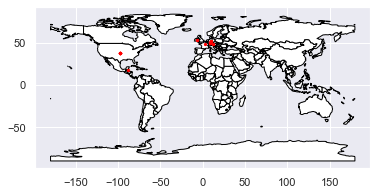

In [17]:
rows = []
for address, count in df_ranked_sources.nlargest(30).iteritems(): # 30 entries limit 
    if address.startswith("192.168."):
        continue
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(address)
    json_response = requests.get(url, headers=headers).json()
    # print(json_response)
    geo = json_response['data']['geo']
    # print(json_response)
    # print(geo)
    # geo['country_name']
    rows.append([geo['ip'], geo['country_code'], geo['longitude'], geo['latitude'], geo['isp']])
    
# as dataframe
df_coord = pd.DataFrame(rows, columns=["ip", "country", "lng", "lat", "isp"])
print(df_coord)
df_coord.to_csv('ipLocations.csv')

# plot on world
g_world = gpd.GeoDataFrame(df_coord, geometry=gpd.points_from_xy(df_coord.lng, df_coord.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
g_world.plot(ax=base, marker='o', color='red', markersize=5)
plt.show()

### IP Locations World Wide Destinations (Outgoing Traffic) ###

                 ip country      lng      lat                          isp
0    188.164.238.26      DE  11.5658  48.1336            SWM Services GmbH
1    52.223.201.182      US -97.8220  37.7510                       TWITCH
2    52.223.201.100      US -97.8220  37.7510                       TWITCH
3   199.232.189.140      DE  11.5658  48.1336                       FASTLY
4    130.61.166.170      DE   8.6295  50.1049             ORACLE-BMC-31898
5     178.79.232.14      US -97.8220  37.7510                         LLNW
6    193.122.47.231      DE   8.6295  50.1049             ORACLE-BMC-31898
7    134.224.101.38      US -97.8220  37.7510                    AMAZON-02
8   199.232.138.248      DE   8.6843  50.1188                       FASTLY
9     52.113.63.202      IE  -6.2591  53.3382  MICROSOFT-CORP-MSN-AS-BLOCK
10   138.246.224.36      DE   9.4910  51.2993        Leibniz-Rechenzentrum
11   134.224.83.155      US -97.8220  37.7510                    AMAZON-02
12    134.224.84.18      

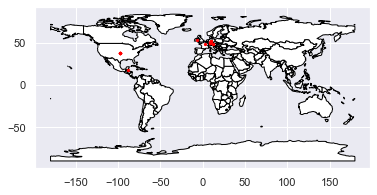

In [18]:
rows = []
for address, count in df_ranked_destinations.nlargest(30).iteritems(): # 30 entries limit 
    if address.startswith("192.168."):
        continue
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(address)
    json_response = requests.get(url, headers=headers).json()
    #print(json_response)
    geo = json_response['data']['geo']
    #print(json_response)
    #print(geo)
    rows.append([geo['ip'], geo['country_code'], geo['longitude'], geo['latitude'], geo['isp']])
    
# as dataframe
df_coord = pd.DataFrame(rows, columns=["ip", "country", "lng", "lat", "isp"])
print(df_coord)
df_coord.to_csv('ipLocations.csv')

# plot on world
g_world = gpd.GeoDataFrame(df_coord, geometry=gpd.points_from_xy(df_coord.lng, df_coord.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
g_world.plot(ax=base, marker='o', color='red', markersize=5)
plt.show()

# Encryption #

To look at the percentage of encrypted traffic we will base our analysis solely on the used protocols. The reason behind this is that we were not able to capture the content of the traffic over time due to the memory intensity and therefore cannot look if the content is encrypted or not.

To distinguish between packages with encrypt content and packages with non-encrypt content we created the following list of protocols that are used to encrypt traffic:
- TLS
- SSH
- SSL
- IPsec
- PGP
- S/MIME
- UDPENCAP
- Kerberos
- ISAKMP
- WireGuard
- DTLSv1.2
- GQUIC
- QUIC
- HART_IP
- LWAPP

Based on this we get the following encryption distribution:

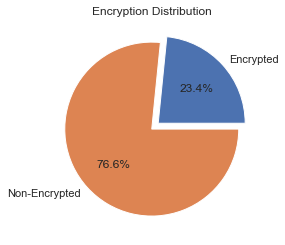

In [19]:
encrypted_protocols = ['SSH', 'SSHv2', 'SSL', 'SSLv3', 'SSLv2', 'TLS', 'TLSv1', 'TLSv1.2', 'TLSv1.3', 'IPsec', 'ESP', 'PGP', 'S/MIME', 'Kerberos', 'ISAKMP', 'UDPENCAP', 'WireGuard', 'DTLSv1.2', 'GQUIC', 'HART_IP', 'LWAPP', 'QUIC']
encrypted_df = df.loc[df['Protocol'].isin(encrypted_protocols)]

content_length_encrypted = encrypted_df['Length'].sum()
content_length_unencrypted = df['Length'].sum()

labels = 'Encrypted', 'Non-Encrypted'
fig, ax = plt.subplots()
plt.title('Encryption Distribution')
ax.pie([content_length_encrypted, content_length_unencrypted - content_length_encrypted], explode=(0.1, 0), labels=labels, autopct='%1.1f%%',)
fig.show()

By inspecting the plot it can quickly be seen that the encrypted packages only take up a small portion of the traffic. However, this number can not be taken as an exact value but as an lower bound since packages send with the UDP and TCP protocol take up most of the traffic but could be encrypted as well. Since don't have the content of the packages we cannot further investigate into the encryption of these. But we suspect that the ecryption percentage would be a lot higher.

# IPv6 vs IPv4

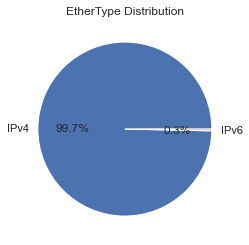

In [20]:
ether_distribution = df.groupby('EtherType').size()

fig, ax = plt.subplots()
plt.title('EtherType Distribution')
ax.pie(ether_distribution, labels=ether_distribution.keys(), autopct='%1.1f%%',)
fig.show()

## DNS 

We would like to investigate further our collected data. Now, we are particular interested in DNS requests. therefore, we filter the data by the protocol "DNS".

In [21]:
df_dns = df[df['Protocol'] == 'DNS']
print(df_dns.head(1))

   Unnamed: 0  No.                        Time          Source Destination  \
0         784  785  2022-01-16 14:02:51.208659  192.168.178.26     8.8.8.8   

  Protocol  Length                                               Info  \
0      DNS      88  Standard query 0x8a78 A ccp-lh.googleuserconte...   

   src port  dst port EtherType        Device Name  index-time  
0   35700.0      53.0      IPv4  Chromecast (Sven)           0  


### Used DNS Server

Various DNS Resolvers exist on the Internet. We would like to find out which our devices are using during their operation. 
Some devices can be configured to use specif DNS Servers, some a DNS resolver hardcoded in their firmware. In man cases the resolve request is just forwarded to the router, who takes care of this. 
By grouping our DNS Destinations and counting the requests, we see which resolvers were primarily used.

In [22]:
df_dns_server = df_dns.loc[~df_dns['Info'].str.contains("response")]
print(df_dns_server.groupby(['Destination']).size())

Destination
192.168.0.1                   4842
192.168.178.1                65771
195.234.128.139                 14
2001:4860:4860::8888           537
217.68.162.126                  19
2a02:2457:10c:101::126          19
8.8.4.4                        127
8.8.8.8                      38438
fd00::e228:6dff:fe67:1d98    39040
fd00::eadf:70ff:fe85:7e17     8451
dtype: int64


We see that most of our DNS requests were send to our routers or well known DNS resolvers, such as Google's 8.8.8.8. However, we also found tree unknown DNS resolvers. A print out of these requests reveals that the Feinstaubsensor IoT device is talking to changing DNS Servers to resolve its destinations.
The other one seems to be an IPv6 DNS resolver, that is used by our Amazon fire TV to resolve its requests. 

In [23]:
print(df_dns_server.loc[df_dns_server['Destination'].str.contains("195.234.128.139")].head(5))
print(df_dns_server.loc[df_dns_server['Destination'].str.contains("217.68.162.126")].head(5))
print(df_dns_server.loc[df_dns_server['Destination'].str.contains("2a02:2457:10c:101::126")].head(5))

          Unnamed: 0      No.                        Time         Source  \
16756395     2822173  2822174  2022-01-18 20:46:11.307159    192.168.0.9   
16756428     2822208  2822209  2022-01-18 20:46:12.009953    192.168.0.9   
20563840     4969974  4969975  2022-01-20 22:08:26.580854  192.168.0.121   
20573224     4971606  4971607  2022-01-20 22:10:54.236053  192.168.0.121   
20582311     4973884  4973885  2022-01-20 22:13:24.235687  192.168.0.121   

              Destination Protocol  Length  \
16756395  195.234.128.139      DNS      89   
16756428  195.234.128.139      DNS     121   
20563840  195.234.128.139      DNS      81   
20573224  195.234.128.139      DNS      81   
20582311  195.234.128.139      DNS      81   

                                                       Info  src port  \
16756395  Standard query 0x0518 A lechmere-v1.sslauth.so...   32962.0   
16756428  Standard query 0x9f57 A conn-i-0d295edec3097db...   41101.0   
20563840      Standard query 0xde91 A server.ch

Another great insight is figuring out what URLs are actually being resolved. This can also be used to track a devices browsing behavior. We count the requests by URL to get a better overview. \
An interesting finding is that many of our top resolved URLs are requested by static devices, such as the Feinstaubsensor, Google Home or the Amazon Fire TV stick. 

Especially on personal computers and mobile devices, a browsing behavior from DNS requests can be found. This includes our love for Reddit. 👨🏽‍🚀

In [24]:
# only look at standart query dns requests
df_dns_requests = df_dns[df_dns['Info'].str.contains('Standard query')]
# exclude responses from count
df_dns_requests = df_dns_requests[~df_dns_requests['Info'].str.contains('response')]
# display URLS
df_dns_urls = df_dns_requests['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print('ns-287.awsdns-35.com' in df_dns_urls.keys())
print(df_dns_urls.head(30))

False
www.google.com                   17255
BRW68140127B12B.fritz.box        12802
ccp-lh.googleusercontent.com      8320
mang.b-cdn.net                    4464
server.chillibits.com             3104
maxi1010.fritz.box                2748
firetvcaptiveportal.com           2731
NULL.fritz.box                    2511
gateway.fe.apple-dns.net          1845
clients3.google.com               1623
wpad.fritz.box                    1540
i.redd.it                         1221
time.google.com                   1175
play.googleapis.com               1131
oauth.reddit.com                  1108
gql.reddit.com                    1001
e.reddit.com                       957
vortex.data.microsoft.com          940
styles.redditmedia.com             877
alb.reddit.com                     867
connectivitycheck.gstatic.com      853
graph.facebook.com                 780
preview.redd.it                    770
safebrowsing.googleapis.com        717
external-preview.redd.it           676
strapi.reddit.com  

### Data traffic over time ###

For following sections, we form 15 minute timeframes and assign data traffic to those timeframes.

In [25]:
def timeMapping(x):
    # apply time difference UTC+1 to labels
    time = datetime.utcfromtimestamp(x*min_15_duration + 3600)
    if time.minute == 0 and time.hour % 6 == 0:
        return time.strftime("%H:%M")
    else:
        return ""

In [26]:




first_entry = df.iloc[0].at['index-time']
last_entry = df.iloc[-1].at['index-time']

print('from ', df.iloc[0].at['Time'], " to ", df.iloc[-1].at['Time'])

x_values_packets = list(range(first_entry, last_entry + 1))
print('Amount of Intervals',len(x_values_packets))

mapping_res = list(map(timeMapping, x_values_packets))


from  2022-01-16 14:02:51.208659  to  2022-01-22 20:48:47.826252
Amount of Intervals 604


In [27]:
# flag for third computation task
values_calculated = False

count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)

df_dict = None


In [28]:
if not values_calculated:
    time_start = time.time()
    print('Compute packet count and data traffic over time 2/2...')
    df_traffic_grouped = df.groupby(['index-time']).Length.sum()
    df_packet_grouped = df.groupby(['index-time']).count()

    for timeframe, values in df_packet_grouped.iterrows():
        # print(ip, timeframe, values['Length'])
        # calculate index
        count_packets[timeframe] += values['Length']
    # break
    for timeframe, values in df_traffic_grouped.iteritems():
        length_packets[timeframe] += values
    length_packets = length_packets // 1000
    time_end = time.time()
    print(time_end - time_start)

Compute packet count and data traffic over time 2/2...
25.110063314437866


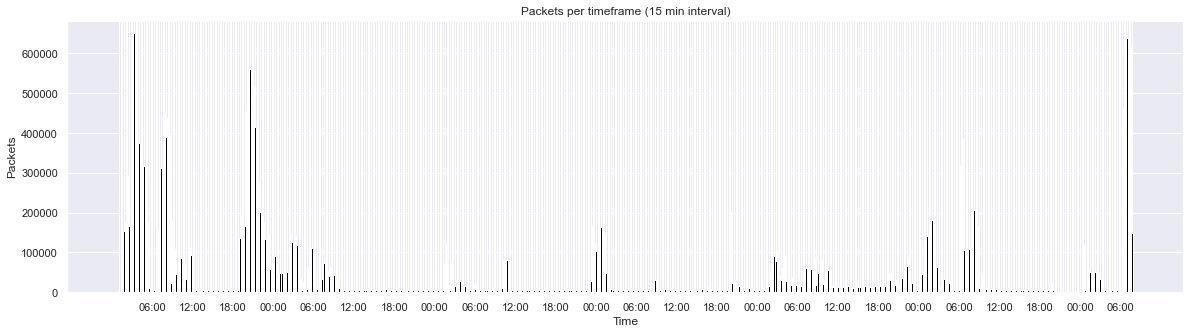

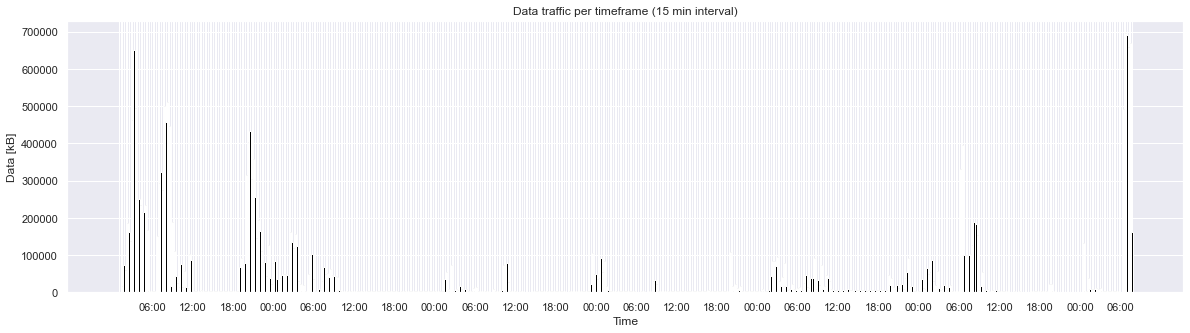

In [29]:
# print(count_packets)
# print(length_packets)
plt.rcParams['figure.figsize'] = [20, 5]
fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()

## Device Evaluation ##

Code for setup:

In [30]:
# define data structure for device metadata
df_device_traffic  = pd.DataFrame() # counts incoming and outgoing data
df_device_packets = pd.DataFrame() # counts incoming and outgoing packets
df_device_dns = pd.DataFrame() # counts dns requests per device

# initialize data structure
for name in devices_labels:
    count_packets_device = np.zeros(2 * (last_entry - first_entry + 1)) # track incoming and outgoing traffic
    length_packets_device = np.zeros(2 * (last_entry - first_entry + 1))
    dns_count = np.zeros(df_dns_urls.size)
    df_device_packets[name] = count_packets_device
    df_device_traffic[name] = length_packets_device
    df_device_dns[name] = dns_count

In [48]:
# Version 2
# incoming traffic
run_device_analysis = False

if run_device_analysis:
    print('Process incoming and outgoing traffic per device...')
    # Outgoing traffic: Device sends traffic
    df_device_out = df.loc[(df['Source'].isin(devices_mapping.keys()))]
    df_device_out_packets = df_device_out.groupby(['Source', 'index-time']).count()
    df_device_out_data = df_device_out.groupby(['Source', 'index-time']).Length.sum()
    # Incoming traffic: Device receives packet
    df_device_in = df.loc[(df['Destination'].isin(devices_mapping.keys()))]
    df_device_in_packets = df_device_in.groupby(['Destination', 'index-time']).count()
    df_device_in_data = df_device_in.groupby(['Destination', 'index-time']).Length.sum()

    # filter DNS request packets, device must have send request
    df_dns_frames = df.loc[df['Source'].isin(devices_mapping.keys()) & (df['Protocol'] == 'DNS') & (df['Info'].str.contains('Standard query'))]
    df_dns_frames = df_dns_frames.loc[~df_dns_frames['Info'].str.contains('response')]
    # apply map function on all frames
    print('Compute dns request apply function...')
    df_dns_frames['dns-request'] = df_dns_frames['Info'].apply(lambda x: x.split(" ")[-1])

    # group by device
    df_dns_device = df_dns_frames.groupby(['Device Name', 'dns-request']).Length.count().sort_values(ascending=False)

# ip address traffic destinations
df_device_ip_dest = df.loc[(df['Source'].isin(devices_mapping.keys()))]
df_device_ip_dest = df_device_ip_dest.groupby(['Device Name', 'Destination']).Length.count().sort_values(ascending=False)

# ip address traffic sources
df_device_ip_source = df.loc[df['Destination'].isin(devices_mapping.keys())]
df_device_ip_source = df_device_ip_source.groupby(['Device Name', 'Source']).Length.count().sort_values(ascending=False)
# df_device_ip_dest.head(50)
# print(df.loc[df['Destination'].str.startswith("192.168")].groupby('Destination').size())

In [40]:
# transfer processed data to data structures
# Process Outgoing traffic
for (ip, timeframe), values in df_device_out_packets.iterrows():
    # print(ip, timeframe, values['Length'])
    # calculate index
    index = 2 * timeframe + 1
    df_device_packets.loc[index, devices_mapping[ip]] += values['Length']
    # break
for (ip, timeframe), values in df_device_out_data.iteritems():
    index = 2 * timeframe + 1
    df_device_traffic.loc[index, devices_mapping[ip]] += values

# Process Incoming traffic
for (ip, timeframe), values in df_device_in_packets.iterrows():
    # print(ip, timeframe, values['Length'])
    # calculate index
    index = 2 * timeframe
    df_device_packets.loc[index, devices_mapping[ip]] += values['Length']
    # break
for (ip, timeframe), values in df_device_in_data.iteritems():
    index = 2 * timeframe
    df_device_traffic.loc[index, devices_mapping[ip]] += values

# Process DNS requests
dns_keys = list(df_dns_urls.keys())
for (label, address), values in df_dns_device.iteritems():
    index = dns_keys.index(address)
    df_device_dns.loc[index, label] += values
# print(df_dns_frames, type(df_dns_frames))

In [43]:
# save to csv
df_dns_urls.to_csv('df_dns_urls.csv')
df_device_traffic.to_csv('df_device_traffic.csv')
df_device_packets.to_csv('df_device_packets.csv')
df_device_dns.to_csv('df_device_dns.csv')

### Device Communication Endpoints ###

#### Outgoing Traffic (Upload) ####
The first place on amount of outgoing packets to the same location goes to the ESP32 and the MVG endpoint ('188.164.238.26').
Maxi's notebook had also many outgoing packets, unfortunately the purpose of packets to the Oracle cloud ('130.61.166.170') or to Limelight Networks ('178.79.232.14') could not be identified. 
Other popular destinations are related to Zoom, Spotify, Amazon and Twitch.
#### Incoming Traffic (Download) ####
The device with the highest download traffic was Maxi's notebook which was used for watching Twitch livestreams ('52.223.201.182' and '52.223.201.100'), communicating with Microsoft ('52.113.63.202') and communicating with some Oracle cloud ('130.61.166.170'). 

Maxi's smartphone often communicated with Reddit, therefore the connection with Fastly's CDN ('199.232.189.140') is no real surprise. Fabian's speaker was also often connected to Fastly CDN, one explanation would content streaming from Spotify ('199.232.138.248'). Sven's Macbook was often involved in Zoom calls ('134.224.101.38'). We observed some traffic from Sven's Chromecast to an Amazon server ('54.182.252.136') which were related to his Amazon Prime video subscription. 

In [51]:
df_device_ip_dest.head(20) # output outgoing traffic


Device Name                    Destination    
ESP32 Microcontroller (Fabi)   188.164.238.26     1057066
Notebook (Maxi)                52.223.201.182      792443
                               52.223.201.100      641974
Android Phone (Maxi)           199.232.189.140     324109
Notebook (Maxi)                130.61.166.170      311446
                               178.79.232.14       292140
                               193.122.47.231      273879
MacBook (Sven)                 134.224.101.38      248261
Sonos Wifi Loudspeaker (Fabi)  199.232.138.248     211853
Notebook (Maxi)                52.113.63.202       192247
                               138.246.224.36      186772
                               134.224.83.155      175186
                               134.224.84.18       158159
                               85.114.135.172      157979
                               185.42.205.193      157829
                               52.115.132.197      134845
                         

In [52]:
df_device_ip_source.head(20) # output popular incoming traffic ip addresses

Device Name                    Source         
Notebook (Maxi)                52.223.201.182     2176128
                               52.223.201.100     1690406
                               52.113.63.202      1391369
                               178.79.232.14      1147835
ESP32 Microcontroller (Fabi)   188.164.238.26     1031790
MacBook (Sven)                 134.224.101.38      803103
Notebook (Maxi)                85.114.135.172      638649
                               52.115.132.197      619752
                               138.246.224.36      566972
Android Phone (Maxi)           199.232.189.140     496683
Sonos Wifi Loudspeaker (Fabi)  199.232.138.248     479584
MacBook (Sven)                 193.122.34.58       456708
Notebook (Maxi)                185.42.205.193      445393
                               130.61.166.170      442012
                               190.115.31.242      356783
                               52.223.201.183      262504
                         

### Traffic by Device ###


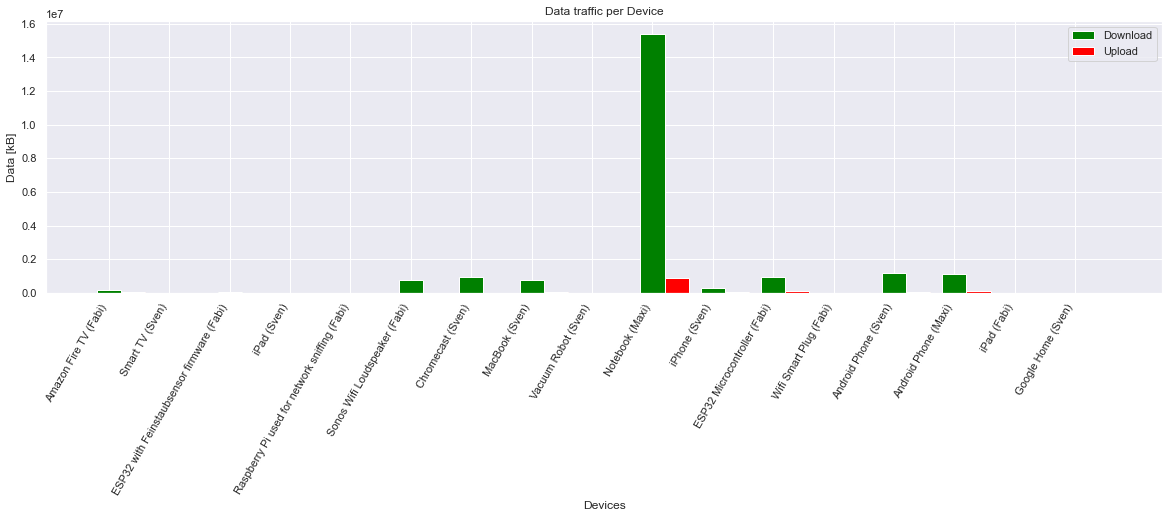

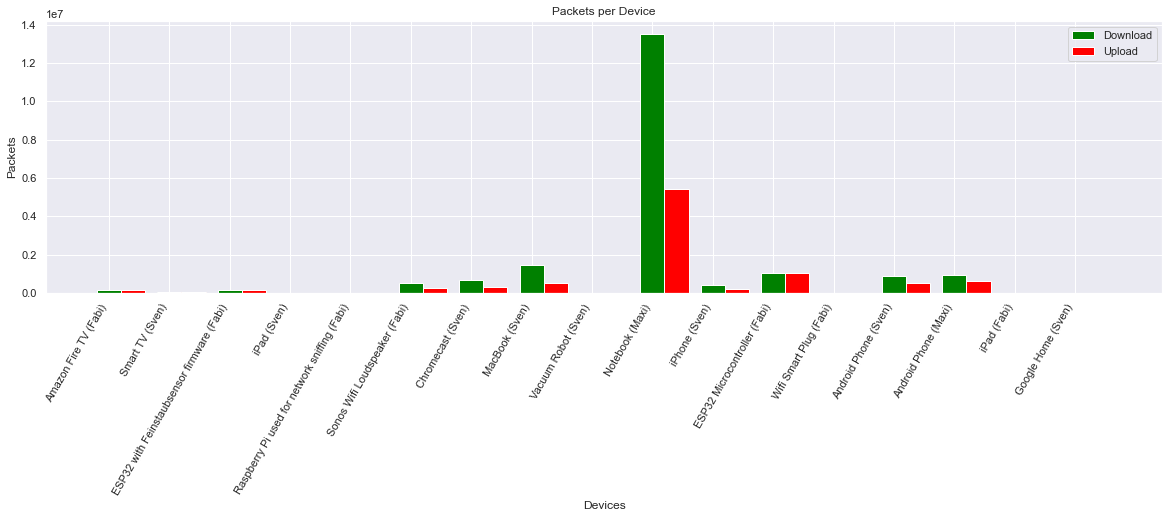

In [38]:
# for each device, plot a bar that shows the data traffic (incoming and outgoing) and amount of packets
# aggregate data
df_device_in_total = (df_device_traffic.iloc[::2].agg(['sum']) // 1000).transpose()# even rows, incoming traffic
df_device_out_total = (df_device_traffic.iloc[1::2].agg(['sum']) //1000).transpose()# odd rows, outgoing traffic
df_device_in_total_num = df_device_in_total['sum'].to_numpy()
df_device_out_total_num = df_device_out_total['sum'].to_numpy()

df_device_in_packets_total = (df_device_packets.iloc[::2].agg(['sum'])).transpose()# even rows, incoming traffic
df_device_out_packets_total = (df_device_packets.iloc[1::2].agg(['sum'])).transpose()# odd rows, outgoing traffic
df_device_in_packets_total_num = df_device_in_packets_total['sum'].to_numpy()
df_device_out_packets_total_num = df_device_out_packets_total['sum'].to_numpy()


fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xlabel('Devices')
plt.ylabel('Data [kB]')
plt.title('Data traffic per Device')
plot_x_devices_traffic = np.arange(len(devices_labels))
plt.xticks(plot_x_devices_traffic, devices_labels, rotation=60, ha="right")
ax.bar(plot_x_devices_traffic, df_device_in_total_num, width=0.4, label="Download", color='green')
ax.bar(plot_x_devices_traffic + 0.4, df_device_out_total_num, width=0.4, label="Upload", color='red')
ax.legend()
fig.show()

# plot packets

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xlabel('Devices')
plt.ylabel('Packets')
plt.title('Packets per Device')
plot_x_devices_traffic = np.arange(len(devices_labels))
plt.xticks(plot_x_devices_traffic, devices_labels, rotation=60, ha="right")
ax.bar(plot_x_devices_traffic, df_device_in_packets_total_num, width=0.4, label="Download", color='green')
ax.bar(plot_x_devices_traffic + 0.4, df_device_out_packets_total_num, width=0.4, label="Upload", color='red')
ax.legend()
fig.show()

### Device Activity ###

The following plot shows at which timeframes packets from or to the device were captured. A single captured packet in a timeframe is sufficient to identify the device as "active". It does not show user activity, but it visualizes when the device was connected to the network and if it was used for data exchange with the web.

For Fabian's measurements, the capture stopped approximately 12 hours than the others and therefore are incomplete for the related devices. Another issue was the connection behaviour of some devices, which connected to a neighbouring Wifi network and the Raspberry Pi could not capture the traffic in certain timeframes (e.g. applicable to iPads and some smartphones).

The first group of devices were always online, some devices send data even during standby phases. Examples are the Fire TV stick, ESP32 device with Feinstaubsensor firmware, the SONOS speaker or the ESP32 with MVG requests. The ESP32 devices were configured by the user to always send requests to endpoints, the more suspicious devices are the speaker and the TV stick with web requests in short intervals. The wifi smart plug was also regularly online, but the intervals between web requests were larger than 15 minutes.

The second group of devices were only sending data while they were switched on, smartphones, notebooks or the Smart TV belong to this group. In the diagrams below, the intervals with an active connection to the Raspberry Pi can be clearly identified. In some cases (e.g. Maxi's smartphone), the device had a permanent connection during the night and still communicated to the Internet although the user was sleeping.

One interesting devices is the vacuum cleaner, which often was active for around 24 hours per session and effectively only worked for a few hours. The Google Home device was also connected for a longer amount of time (e.g.6 am to 0 am) until it was switched off until the next day.

(17, 604)


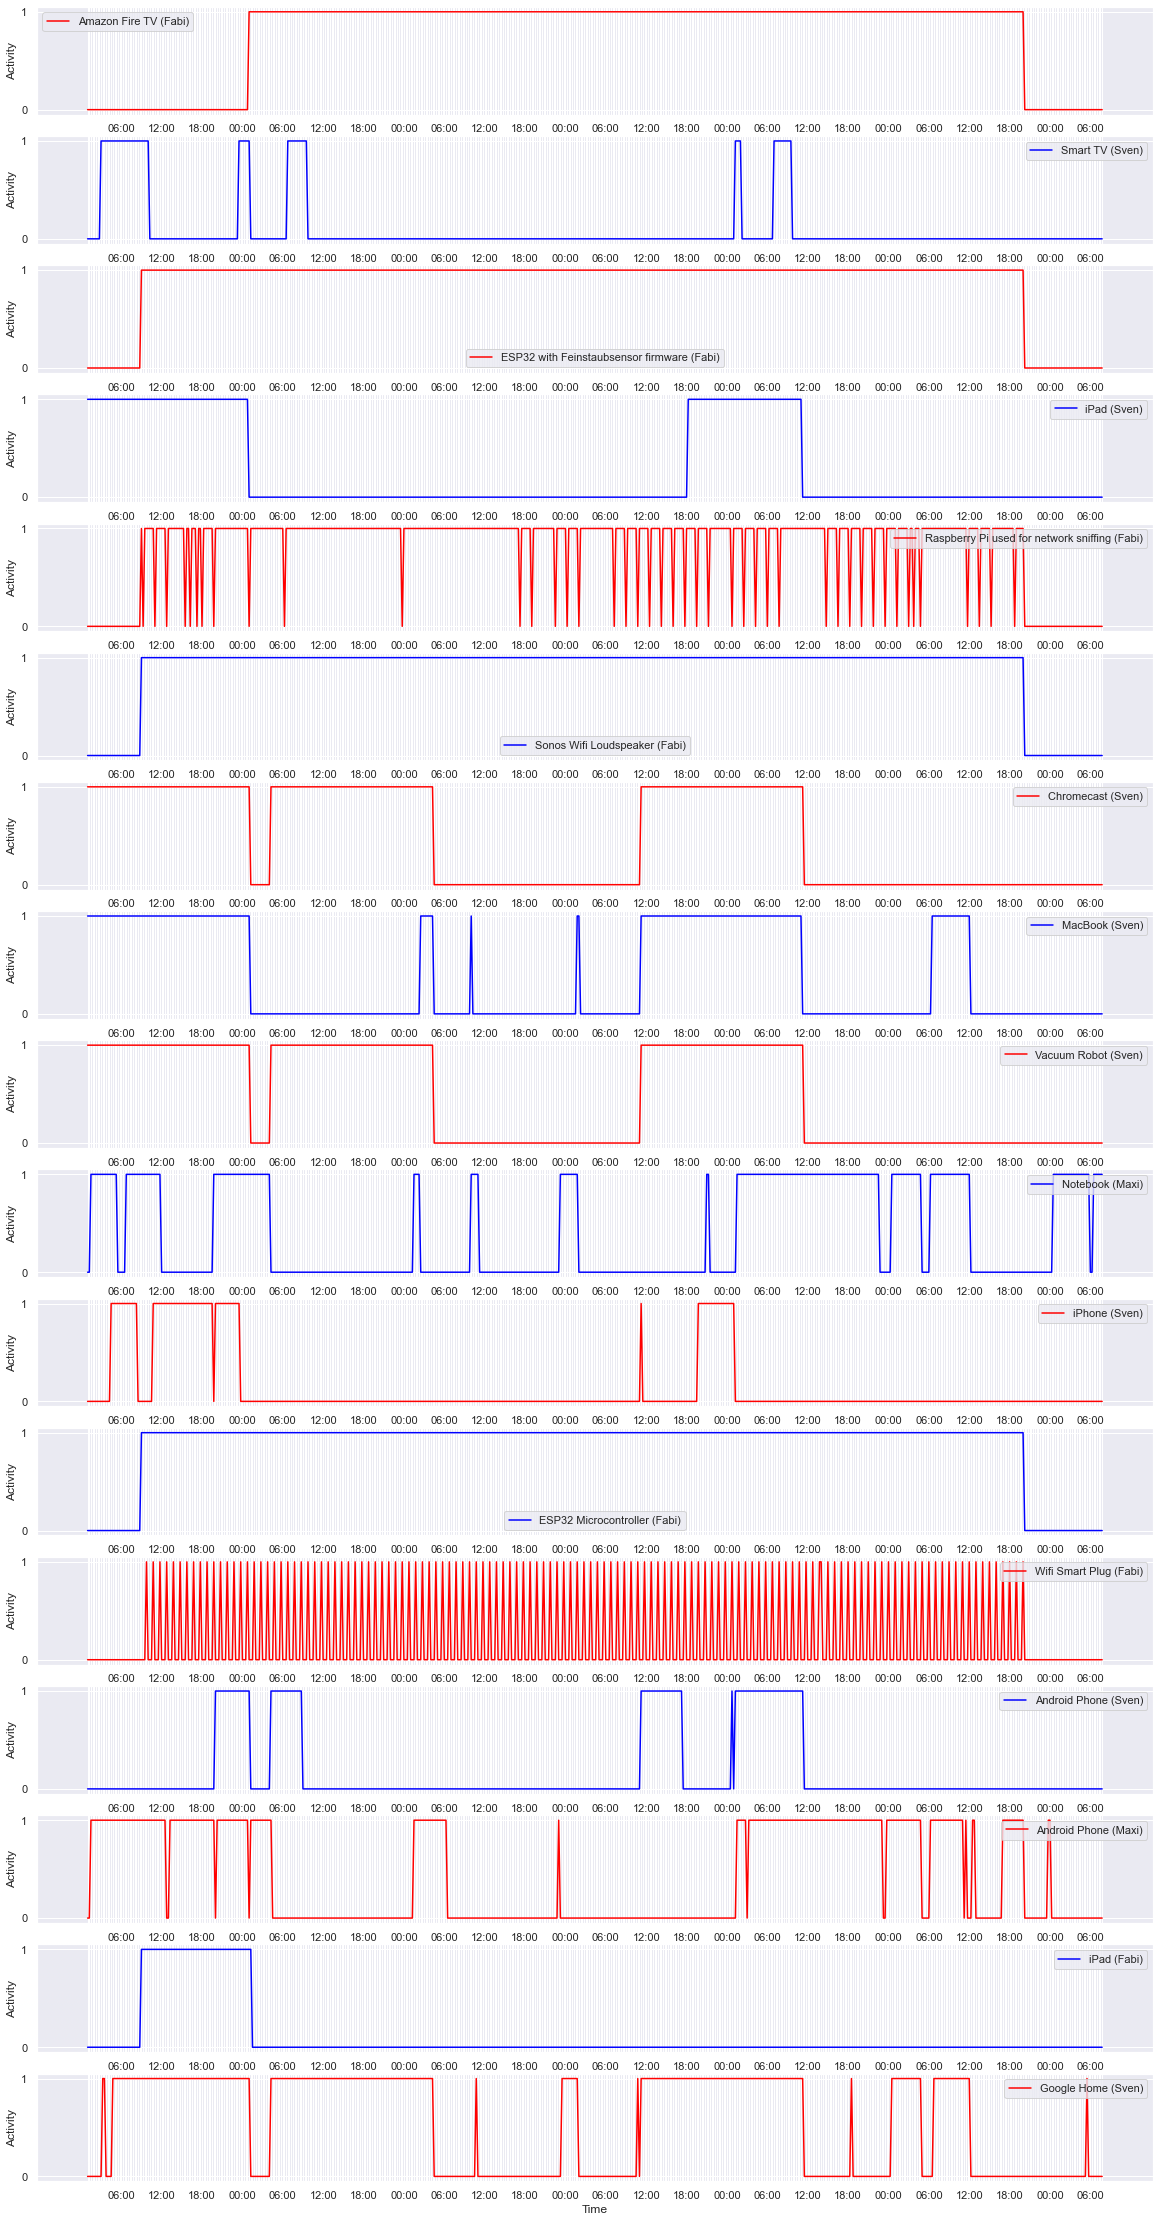

In [35]:
# plot activity
# activity = 1 packet send/received within a timeframe
packets_1 = df_device_packets.iloc[::2].to_numpy()
packets_2 = df_device_packets.iloc[1::2].to_numpy()

combined = np.minimum(np.add(packets_1, packets_2), 1).transpose()
# print(df_device_packets.iloc[::2])
print(combined.shape)
plot_X_activity = np.arange(combined.shape[1])

# print(np.minimum(combined[0], (len(combined[0])) * [1] ))

# df_device_packets.iloc[1::2]
fig, ax = plt.subplots(nrows=combined.shape[0], ncols=1, figsize=[20, 40])
# plt.figure(figsize=[20, 30])
# plt.rcParams['figure.figsize'] = [20, 40]
#plt.xlabel('Time')
#plt.ylabel('Activity')
#plt.title('Packets per Device')
# plt.xticks(x_values_packets, mapping_res)
plt.setp(ax, xticks=x_values_packets, xticklabels=mapping_res,
        yticks=[0, 1],xlabel='Time', ylabel="Activity", )

for index in range(combined.shape[0]):
    # plt.subplot(combined.shape[0], 1, index+1)
    if index % 2 == 0:
        ax[index].plot(x_values_packets, combined[index], label=devices_labels[index], color="red")
    else:
        ax[index].plot(x_values_packets, combined[index], label=devices_labels[index], color="blue")
    ax[index].legend()


fig.show()

### Night Behaviour and Application Behaviour ###
- Top DNS request targets day/night (6 hour intervals)
- Analyze night behaviour (0-6 am) (low activity, find destination IP addresses, country, isp, protocols)
- Outgoing/Incoming traffic difference
- Application Activity (e.g. Google, Twitch, MVG, etc.)

We wanted to know how devices behaved at night without user interaction. Therefore, we decided to only use captured data between 0 and 6am for the first section.
In the second section, we want to find out more about application behaviour, e.g. when any Google application is active. Therefore, we assign to each larger application a set of ip addresses (e.g. via resolving collected dns requests) and plot the activity of the applications.

In [ ]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()

Find the mule
Suspicious H1 protocol sends large amount of data to cloud
MVG thingy
Staubsauger

End of the notebook